#### This program takes a modular approach. The user can provide all the initial details at the beginning. The Hough Algorithm then gives the output at its maximum accuracy. 

In [326]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas
import math
import random
import cv2
import scipy.ndimage.filters as filters
import scipy.ndimage as ndimage
from scipy import stats 
import sklearn.metrics as metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

In [327]:
def get_image(pixel,SNR,sigma,alpha,xbar,ybar):
    for i in range(0,20):
        for j in range(0,20):
            intensity=SNR*exp(-((((j-ybar))*cos(alpha))-(((i-xbar))*sin(alpha)))**2/(2*(sigma)**2))
            pixel[i,j]=(intensity,intensity,0)
    return pixel

In [328]:
def get_gray(image):
    pixel_gray=np.dot(pixel, [1,1,1])
    return pixel_gray

In [329]:
def get_binary_gray(pixel_gray):
    for i in range(0,20):
        for j in range(0,20):
            if(pixel_gray[i,j]>=(np.max(pixel_gray))/2):
                binary_gray[i,j]=(1,1,1)
            else:
                binary_gray[i,j]=(0,0,0)
    return binary_gray

In [330]:
def get_pixel_new(pixel_gray):
    noise=np.random.normal(0,1,(20,20))               
    pixel_new = np.abs(sqrt(SNR)*pixel_gray + noise)
    return pixel_new

In [331]:
def get_pixel_new_binary(pixel_new,th_pixel_gray):
    pixel_new_binary=np.zeros(shape=(20,20))
    for i in range(0,20):
        for j in range(0,20):
            if (pixel_new[i,j]>th):
                pixel_new_binary[i,j]=1
    return pixel_new_binary

In [332]:
def get_noisy_binary_img(pixel_new_binary):
    
    noisy_binary_img= mpimg.imread(r"\Users\Kaustav Dutta\Desktop\test.png");
   # noisy_binary_img=np.where(pixel_new_binary[i,j]==0,(0,0,0))
    
    for i in range(0,20):
        for j in range(0,20):
            if (pixel_new_binary[i,j]==0):
                noisy_binary_img[i,j]=(0,0,0)
    return noisy_binary_img

In [333]:
def get_hough_space(pixel_new_binary):
    pixel_new_shape = pixel_new.shape

    x_max = pixel_new_shape[0]
    y_max = pixel_new_shape[1]

    theta_max = 1.0 * math.pi 
    theta_min = 0.0

    r_min = 0.0
    r_max = math.hypot(x_max, y_max)

    r_dim = 200 
    theta_dim = 300

    count_coord=25
    points_x=np.zeros(shape=(r_dim,theta_dim,count_coord),dtype='int')
    points_y=np.zeros(shape=(r_dim,theta_dim,count_coord),dtype='int')
    count=np.zeros(shape=(r_dim,theta_dim),dtype='int')

    hough_space = np.zeros((r_dim,theta_dim,))

    for x in range(x_max):
        for y in range(y_max):
            if pixel_new_binary[x,y] == 0: continue
            for itheta in range(theta_dim):
                
                theta =1.0 *itheta * theta_max / theta_dim
                r = x * math.cos(theta) + y * math.sin(theta)
                ir = int(r_dim * ( 1.0 * r ) / r_max)
                        
                points_x[ir,itheta,count[ir,itheta]]=x
                points_y[ir,itheta,count[ir,itheta]]=y
               
                count[ir,itheta]=count[ir,itheta]+1
            
                hough_space[ir,itheta] = hough_space[ir,itheta] + 1
                
    return hough_space,count,points_x,points_y             

In [334]:
def get_max_accuracy(pixel_gray):
    max_points=int(math.hypot(pixel.shape[0],pixel.shape[1]))
    accuracy=np.zeros(max_points)
    max_accuracy_index=0
    
    y_true=np.zeros(shape=(pixel.shape[0],pixel.shape[1]))
    for i in range(0,20):
        for j in range(0,20):
            if(pixel_gray[i,j]>=(np.max(pixel_gray))/4):
                y_true[i,j]=1
    y_true=y_true.flatten()
    
    for thresh in range(0,max_points):
        y_pred=np.zeros(shape=(pixel.shape[0],pixel.shape[1]))
        hough_space_binary=np.zeros(shape=(r_dim,theta_dim))
        for i in range(hough_space.shape[0]):
            for j in range(hough_space.shape[1]):
                if (hough_space[i,j]>=thresh):
                    hough_space_binary[i,j]=1
                
        for r in range(hough_space.shape[0]):
            for theta in range(hough_space.shape[1]):
                if(hough_space_binary[r,theta]==1):
                    for l in range(count[r,theta]):
                        y_pred[points_x[r,theta,l],points_y[r,theta,l]]=1
                      
        y_pred=y_pred.flatten()
        accuracy[thresh]=metrics.accuracy_score(y_true, y_pred)
        if(accuracy[thresh]==np.max(accuracy)):
            max_accuracy_index=thresh
            
    return accuracy,max_accuracy_index

In [343]:
def get_reverse_hough(hough_space,index,count,points_x,points_y):
    hough_space_binary=np.zeros(shape=(r_dim,theta_dim))
    for i in range(hough_space.shape[0]):
        for j in range(hough_space.shape[1]):
            if (hough_space[i,j]>=index):
                hough_space_binary[i,j]=1

    reverse_hough = mpimg.imread(r"\Users\Kaustav Dutta\Desktop\reverse_hough.png")
    for r in range(hough_space.shape[0]):
        for theta in range(hough_space.shape[1]):
            if(hough_space_binary[r,theta]==1):
                for l in range(count[r,theta]):
                    reverse_hough[points_x[r,theta,l],points_y[r,theta,l]]=(1,1,1)
                    
    return reverse_hough

In [344]:
def show_all(binary_gray,noisy_binary_img,reverse_hough):
    plt.figure(figsize=(11,11))
    plt.subplot(131), plt.imshow(binary_gray,origin='lower'),plt.title('True Binary Spectrogram')
    plt.subplot(132), plt.imshow(noisy_binary_img,origin='lower'),plt.title('Binary spectrogram with Gaussian Noise')
    plt.subplot(133), plt.imshow(reverse_hough,origin='lower'),plt.title('Reverse Hough Spectrogram')
    plt.show()

In [347]:
sqrt=math.sqrt
pi=math.pi
alpha=0.785398
sigma=1
ybar=10
xbar=10
exp=math.exp
cos=math.cos
sin=math.sin
SNR=I0
f=0.8

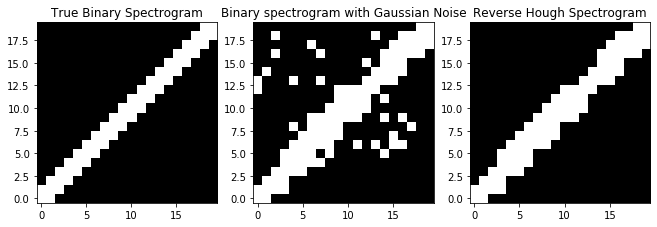

In [348]:
image=get_image(pixel,SNR,sigma,alpha,xbar,ybar) #to get the track without any noise
pixel_gray=get_gray(image)#to get the grayscale of the track image
binary_gray=get_binary_gray(pixel_gray)#to get the true track pixels
pixel_new=get_pixel_new(pixel_gray)#to introduce gaussian noise into the image

th_pixel_gray=f*np.max(pixel_gray) #threshold for the pixels on which the Hough Algorithm will work

pixel_new_binary=get_pixel_new_binary(pixel_new,th_pixel_gray) #binary matrix based on the threshold
noisy_binary_img=get_noisy_binary_img(pixel_new_binary) #noisy image on which Hough Algorithm will work
hough_space,count,points_x,points_y=get_hough_space(pixel_new_binary)#hogue space generator
max_accuracy,index=get_max_accuracy(pixel_gray) #gives the maximum accuracy of the Hough Transform
reverse_hough=get_reverse_hough(hough_space,index,count,points_x,points_y) #gives the final hough transform 
show_all(binary_gray,noisy_binary_img,reverse_hough) #compares the different stages of the algorithm